In [1]:
from os.path import join
from typing import List, Dict
import random
import json
import torch
import torch.nn as nn
import h5py
import numpy as np
import matplotlib.pyplot as plt
import librosa
import itertools
from IPython.display import Audio
import soundfile as sf
from tqdm import tqdm

from module.eval import F_measure, Kulback_Leibler
from models.wav_cmcmcmcl import Architecture

In [2]:
class RunPTH():
    def __init__(self, model: nn.Module, pth_path: str, bins_path: str, h5_path: str) -> None:
        self.pth_path = pth_path
        self.bins_path = bins_path
        self.h5_path = h5_path
        self.seed = 1000
        self.split = 0.9
        self.model = model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def getTestIDs(self, bins: List[str]) -> List[str]:
        # Setting seed for reproducibility
        random.seed(self.seed)

        # Making set of song ids
        songs = {"-".join(key.split("-")[:2]) for key in bins}

        # Getting a list of test songs
        test_songs = songs - set(random.sample(list(sorted(songs)), round(self.split * len(songs))))

        # Making lists of ids for test songs
        test_ids = [key for key in bins if "-".join(key.split("-")[:2]) in test_songs]

        return test_ids

    def getPrediction(self, song_data: List[float], target: List[int]) -> List[int]:
        # Converting to tensors
        song_data = torch.tensor(song_data, dtype=torch.float32)

        # Sending data to GPU
        song_data = song_data.to(self.device)

        return self.model(song_data).squeeze().tolist()

    def run(self) -> (Dict[str, List[int]], Dict[str, List[int]]):
        # Loading data_snippet_bin_430.json
        with open(self.bins_path, "r") as file:
            bins = json.load(file)

        # Getting test ids
        test_ids = self.getTestIDs(bins.keys())

        # Getting targets
        targets = {key+"-512-256.npy": bins[key] for key in test_ids}

        # Loading model from pth file
        self.model.load_state_dict(torch.load(self.pth_path))
        self.model.to(self.device)
        self.model.eval()

        # Making predictions from h5 spect file
        predictions = {}
        with h5py.File(self.h5_path, 'r') as file:
            counter = 0
            for name in file:
                if "-".join(name.split("-")[:3]) in ["1985-150-56000",'1998-1435-96000','2015-3598-96000','2015-3653-197000','2018-4049-302000','2020-4249-19000','2019-4129-127000','2020-4249-0','2016-3712-41000','2009-2815-106000','2017-3951-89000','1988-405-155000']:
                    predictions[name] = self.getPrediction(file[name][()], targets[name])
                # if "-".join(name.split("-")[:3]) in test_ids:
                #     predictions[name] = self.getPrediction(file[name][()], targets[name])
                    # if counter < 140:
                    #     counter += 1
                    # # if counter > 140:
                    # #     break
                    # else:
                    #     predictions[name] = self.getPrediction(file[name][()], targets[name])
                    #     counter += 1
            # predictions = {name: self.getPrediction(file[name]) for name in file if "-".join(name.split("-")[:3]) in test_ids}
                        
        print("predictions made:", len(predictions))

        return predictions, targets
    
    def setSeed(self, seed: int) -> None:
        self.seed = seed

    def setSplit(self, split: float) -> None:
        self.split = split

    def setPthPath(self, pth_path: str) -> None:
        self.pth_path = pth_path

    def setBinsPath(self, bins_path: str) -> None:
        self.bins_path = bins_path

In [3]:
root = r"C:\Users\david\OneDrive - Danmarks Tekniske Universitet\S1-intsys\Eksamensprojekt"
path_pth = join(root, "Davids Rodemappe", "training_models", "wav_cmcmcmcl_LR_1_BATCH_32_DROP_0.9_CRIT_BCELoss_OPTI_Adadelta_SCHE_ReduceLROnPlateau_1.pth")
path_bins = join(root, "Davids Rodemappe", "data", "data_snippet_bin_430.json")
path_h5 = join(root, "Davids Rodemappe", "bin", "data_wav_27520_npy.h5")

In [4]:
def plotTogether(target_to_plot, prediction_to_plot, peaks, key):
    beats_a = [i for i, x in enumerate(target_to_plot) if x == 1]
    for i in beats_a:
        plt.axvline(i, color='gray', linestyle='dotted', ymin=0, ymax=1, linewidth=0.5)
    plt.bar(range(len(prediction_to_plot)), prediction_to_plot)
    for i in peaks:
        plt.axvline(i, color='r', ymin=0.9, ymax=1.0, linewidth=2)
    plt.title(key)
    plt.show()

predictions made: 12


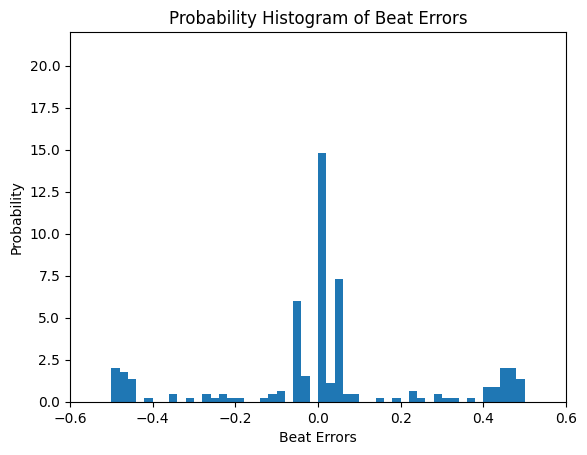

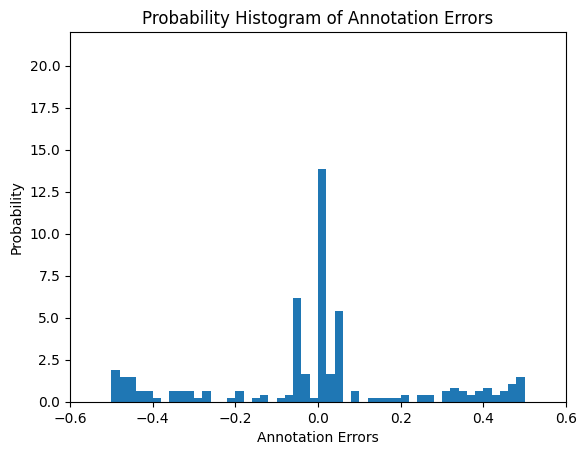

(1.485316073067004, (1.3814303285950544, 1.8786200968347013))
58.5% : pre_max=5 post_max=9 pre_avg=5 post_avg=7 delta=0.04 wait=15


In [5]:
model = Architecture()
pthRunner = RunPTH(model, path_pth, path_bins, path_h5)
predictions, targets = pthRunner.run()

np_predictions = {key: np.array(predictions[key]) for key in predictions}
npp_sum = {key: np.sum(np_predictions[key]) for key in np_predictions}

np_targets = {key: np.array(targets[key]) for key in targets}
npt_sum = {key: np.sum(np_targets[key]) for key in np_targets}

PRINT_PLOTS = False
PRINT_LISTS = False

pre_max = [5] # 5 --> 5
post_max = [9] # 7 --> 9
pre_avg = [5] # 3 --> 5
post_avg = [7] # 5 --> 7
delta = [0.04] # 0.04 --> 0.04
wait = [15] # 15 --> 15

all_peaks = {}
accuracies = {}
# measures_F = {}
# measures_K = {}

def calcAccuracy(pre_max, post_max, pre_avg, post_avg, delta, wait):
    predictionsToFmeasure = {}
    targetsToFmeasure = {}

    for key in list(predictions.keys()):
        all_peaks[key] = librosa.util.peak_pick(np_predictions[key], pre_max=pre_max, post_max=post_max, pre_avg=pre_avg, post_avg=post_avg, delta=delta, wait=wait)

        predictionsToFmeasure[key] = list(all_peaks[key] * 23.3)

        # Find idxs of 1s in np_targets[key]
        targetsToFmeasure[key] = list(np.array([i for i, x in enumerate(np_targets[key]) if x == 1]) * 23.3)

        # plotTogether(np_targets[key], np_predictions[key], all_peaks[key], key)
    
    # Save predictionsToFmeasure as json file in data folder
    with open(join(root, "Davids Rodemappe", "data", "data_predictions_wav.json"), "w") as file:
        json.dump(predictionsToFmeasure, file)

    # for key in tqdm(predictionsToFmeasure):
    #     if(len(predictionsToFmeasure[key]) < 5):
    #         continue
    #     if(len(targetsToFmeasure[key]) < 5):
    #         continue

    #     measures_F[key] = round(F_measure([predictionsToFmeasure[key]], [targetsToFmeasure[key]]) * 100, 1)
    #     measures_K[key] = Kulback_Leibler([predictionsToFmeasure[key]], [targetsToFmeasure[key]], show_hist=False)

    run_pct = round(F_measure(predictionsToFmeasure, targetsToFmeasure) * 100, 1)
    run_id = f"pre_max={pre_max} post_max={post_max} pre_avg={pre_avg} post_avg={post_avg} delta={delta} wait={wait}"

    print(Kulback_Leibler(predictionsToFmeasure, targetsToFmeasure, show_hist=True))

    accuracies[run_id] = run_pct
    print(f"{run_pct}% : {run_id}")

for combination in itertools.product(pre_max, post_max, pre_avg, post_avg, delta, wait):
    # Unpack the parameters
    p_max, po_max, p_avg, po_avg, delta, wait = combination

    # Call your function
    calcAccuracy(p_max, po_max, p_avg, po_avg, delta, wait)

In [6]:
# print(len(measures_F))
# print(measures_F)
# print(len(measures_K))
# print(measures_K)

In [7]:
# # Save measures_F and measures_K as json files in data folder
# with open(join(root, "Davids Rodemappe", "data", "data_wav_Fm.json"), "w") as file:
#     json.dump(measures_F, file)

# with open(join(root, "Davids Rodemappe", "data", "data_wav_Km.json"), "w") as file:
#     json.dump(measures_K, file)

In [8]:
# Print keys and values from accuracies
for key, value in accuracies.items():
    print(f"{value}% ... {key}")

58.5% ... pre_max=5 post_max=9 pre_avg=5 post_avg=7 delta=0.04 wait=15


In [9]:
# Print max value in accuracies and its key
max_key = max(accuracies, key=accuracies.get)
max_value = accuracies[max_key]
print(f"Max value: {max_value}% ... {max_key}")

Max value: 58.5% ... pre_max=5 post_max=9 pre_avg=5 post_avg=7 delta=0.04 wait=15


In [10]:
# plotTogether(target_to_plot, prediction_to_plot, peaks)

first_key = 140
last_key = 150

# Plot 10 example graphs
for i, k in enumerate(predictions.keys()):
    if i < first_key or i > last_key:
        continue
    
    plotTogether(np_targets[k], np_predictions[k], all_peaks[k], k)

In [12]:
# Get the first key as string
random.seed(1111)
fk_contents = random.sample(list(predictions.keys()), 10)
fk_ids = ["-".join(_.split("-")[:3]) for _ in fk_contents]

def storeSongExamples(idx, cnt):
    # Song path
    song_path = join(root, "DataWav", idx+".wav")
    print(song_path)

    # Get song peaks
    song_peaks = all_peaks[cnt]
    print(song_peaks)

    # Import song via librosa
    y, sr = librosa.load(song_path, sr=44100)
    print(f"y (librosa) : {len(y)} : ", set(y))

    # Setup clicks to be played in Audio using librosa
    y_clicks = librosa.clicks(times=(song_peaks / 1000) * 23.3, sr=sr, length=len(y))
    print(f"clicks (librosa) : {len(y_clicks)} : ", set(y_clicks))

    # Listen to song using Audio()
    Audio(data=y+y_clicks, rate=sr)

    # Export audio to .wav file in audio folder
    sf.write(join(root, "DataBip", f"{idx}_wav.wav"), y+y_clicks, sr, subtype='PCM_24')

for i, c in enumerate(fk_contents):
    storeSongExamples(fk_ids[i], c)

C:\Users\david\OneDrive - Danmarks Tekniske Universitet\S1-intsys\Eksamensprojekt\DataWav\2009-2815-106000.wav
[  0  19  35  53  70  86 111 138 155 180 206 224 240 258 275 292 308 343
 359 385 411 428]
y (librosa) : 441000 :  {0.012939453, -0.0078125, -0.033203125, -0.024475098, -0.031219482, -0.036621094, -0.025146484, 0.004180908, 0.040740967, 0.07296753, 0.09805298, 0.10397339, 0.097839355, 0.08999634, 0.07357788, 0.056671143, 0.62472534, 0.61502075, 0.61016846, 0.5956116, 0.60046387, 0.5907593, 0.585907, 0.5810547, 0.5762024, 0.5713501, -0.39468384, -0.38012695, 0.10046387, -0.38497925, -0.40438843, -0.40924072, -0.38983154, -0.41409302, 0.09561157, 0.08105469, 0.5470886, 0.5616455, 0.5422363, 0.53738403, 0.53253174, 0.52282715, 0.51797485, 0.51312256, 0.50827026, -0.41275024, -0.35025024, 0.14974976, -0.22525024, 0.33724976, -0.16275024, 0.39974976, 0.024749756, -0.100250244, 0.087249756, 0.48886108, 0.4791565, 0.49371338, 0.4743042, 0.4840088, 0.4694519, 0.4645996, 0.4597473, 0.4